In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-06-07 21:40:41.598729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 21:40:42.859460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-07 21:40:42.859585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-07 21:40:42.859601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#metrics= [sigma_loss,sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
metrics= [sigma_loss,sigma_batch_loss,mse_tau,mse_sigma,sigma_f_loss]
home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_6_6_23/"
#r_like=[0.01,0.06,0.07,0.08] #these are the r_test of the maps on which i test the NN 
r_like=[0.0,0.001,0.005,0.007,0.01] #these are the r_test of the maps on which i test the NN 
sigma_exact=[0.000225922*2, 0.000398311, 0.001017338,0.001142098,0.0015324*2] #these are the sigma computed for the 
#r_test using the likelihood approach
#sigma_exact=[0.00073*2, 0.000398311, 0.00207732328746706,0.002335838427700651] tau 0.01,0.06,0.07,0.08
load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
to_load=["test_data_r000_t006_24.npz","test_data_r001_t006_24.npz","test_data_r005_t006_24.npz",
         "test_data_r007_t006_24.npz","test_data_r0010_t006_24.npz"] #these are the test maps
#to_load=["test_data_005_40.npz","test_data_007_40.npz"]
loss_kind="var" #var
loss_training=sigma_log_loss 
test_model_folder="test_model"

In [3]:
try:
    hyperparameters=pd.read_csv(home_dir+"output.txt",delim_whitespace=True, index_col=None) #i try to read the 
    #file with the hyperparameters used in the training
except:
    print("no file to read") 
    dataframe={}
    dataframe["no data"]=["-"]
    hyperparameters=pd.DataFrame(dataframe)#if there is no file to read (because i analyse an old model) i create an 
    #empty dataframe
finally:
    None #i use this so that the program continue after the try,except
print(hyperparameters)

     name            loss  noise  p_stopping  p_reduce  f_reduce  \
0  6_6_23  sigma_log_loss      4          20         5       0.5   

         stop-reduce       lr  batch_size  n_layers  nodes_layers  \
0  val_loss-val_loss  0.00003          32      True            48   

                            comments  
0  best hyperparameters double check  


In [4]:
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    x_test.append(f["x_test"])
    y=np.zeros(len(x_test[i]))+f["y_test"] #y_test is a single number in the file -> i need to transform it in an array
    #of the same length of x_test
    y_test.append(y.reshape(y.shape[0],1))

In [5]:
model = keras.models.load_model(
    home_dir+test_model_folder,  custom_objects={'loss_training' : loss_training, 'metrics' : metrics}, 
    compile=False
) #i restore the model from the test_model folder. I need to specify the custom objects and recompile the model with the custom
#objects, thus the metrics and the loss functions
model.compile(loss=loss_training,optimizer=tf.optimizers.Adam(), metrics=metrics)

results=[]
predictions=[]
for x,y in zip(x_test,y_test): #i compute the predictions of the model for each test_set and save them in a dict
    results.append(model.evaluate(x,y,verbose=2) )
    predictions.append(model.predict(x))
npz_dict={}
for i,p in enumerate(predictions):
    npz_dict[f"sigma_{r_like[i]}"]=p[:,1]
np.savez(home_dir+"sigma_out", **npz_dict)

2023-06-07 21:40:51.401500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-07 21:40:51.401781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-06-07 21:40:51.403231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 - 8s - loss: 2.8599e-06 - sigma_loss: 7.7121e-06 - sigma_batch_loss: 1.7721e-05 - mse_tau: 2.8573e-06 - mse_sigma: 4.8548e-06 - sigma_f_loss: 485.4786 - 8s/epoch - 26ms/step
313/313 [==============================] - 7s 20ms/step
313/313 - 6s - loss: 6.5629e-06 - sigma_loss: 9.2560e-06 - sigma_batch_loss: 2.3749e-05 - mse_tau: 6.5579e-06 - mse_sigma: 2.6981e-06 - sigma_f_loss: 269.8120 - 6s/epoch - 19ms/step
313/313 [==============================] - 6s 20ms/step
313/313 - 6s - loss: 3.4410e-05 - sigma_loss: 4.6576e-05 - sigma_batch_loss: 1.1980e-04 - mse_tau: 3.4385e-05 - mse_sigma: 1.2191e-05 - sigma_f_loss: 1219.1267 - 6s/epoch - 20ms/step
313/313 [==============================] - 6s 20ms/step
313/313 - 6s - loss: 3.2523e-05 - sigma_loss: 5.4107e-05 - sigma_batch_loss: 1.3708e-04 - mse_tau: 3.2504e-05 - mse_sigma: 2.1603e-05 - sigma_f_loss: 2160.3032 - 6s/epoch - 19ms/step
313/313 [==============================] - 6s 19ms/step
313/313 - 6s - loss: 6.3757e-05 - sigma_loss: 

In [6]:
print(npz_dict[f"sigma_{r_like[0]}"])

[-0.0004018  -0.00028423 -0.00026461 ... -0.00045902 -0.00031453
 -0.00040275]


In [7]:
if loss_kind=="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    sigma_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_sigma=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_sigma=[]
    median_r=[]
    median_sigma=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        sigma_pred.append(p[:,1])
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.mean(sigma_pred[i]))
        sigma_sigma.append(np.std(sigma_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_sigma.append(np.sum(((sigma_pred[i]-sigma_est[i])/sigma_sigma[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_sigma.append(np.median(sigma_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_sigma"]=sigma_sigma
    d["median_sigma-sigma_est"]=np.asarray(median_sigma)-np.asarray(sigma_est)
    d["skeweness_sigma"]=skeweness_sigma

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

In [8]:
if loss_kind=="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the average of the $\sigma_{i}$ estimated by the network on the test set.")
        print("\n")

In [9]:
#print(r_pred[0][:100])

In [10]:
if loss_kind=="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(np.abs(sigma_pred[i]), bins='fd')
        counts_sigma, bins_sigma = np.histogram(np.abs(sigma_pred[i]), bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="std estimated by NN",  color='k')
        plt.axvline(sigma_r[i], color="black", linestyle="--", label="std on the r estimated by NN")
        plt.axvline(np.abs(sigma_est[i]), color="red", linestyle="-", label="Average of the std estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$\sigma_{r}^{NN}$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank

In [11]:
if loss_kind!="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    var_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_var=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_var=[]
    median_r=[]
    median_var=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        #var_pred.append(p[:,1])
        var_pred.append(p[:,1]**2)
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.sqrt(np.mean(var_pred[i])))
        sigma_var.append(np.std(var_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_var.append(np.sum(((var_pred[i]-sigma_est[i]**2)/sigma_var[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_var.append(np.median(var_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_var"]=sigma_var
    d["median_var-var_est"]=np.asarray(median_var)-np.asarray(sigma_est)**2
    d["skeweness_var"]=skeweness_var

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

     name            loss noise p_stopping p_reduce f_reduce  \
0  6_6_23  sigma_log_loss     4         20        5      0.5   
1  6_6_23  sigma_log_loss     4         20        5      0.5   
2  6_6_23  sigma_log_loss     4         20        5      0.5   
3  6_6_23  sigma_log_loss     4         20        5      0.5   
4  6_6_23  sigma_log_loss     4         20        5      0.5   

         stop-reduce       lr batch_size n_layers  ... median_r-r_est  \
0  val_loss-val_loss  0.00003         32     True  ...      -0.000022   
1  val_loss-val_loss  0.00003         32     True  ...      -0.000036   
2  val_loss-val_loss  0.00003         32     True  ...      -0.000038   
3  val_loss-val_loss  0.00003         32     True  ...       0.000096   
4  val_loss-val_loss  0.00003         32     True  ...       0.000056   

      mae_r  skeweness_r   sigma_r  sigma_est    dsigma     dlike  \
0  0.000145     0.841318  0.000187   0.000390  0.521192  1.421315   
1  0.000340     0.549661  0.000426   0

In [12]:
if loss_kind!="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance")
        print("\n")

on_test_set r = 0.0
r_est: 0.00023368934   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.000186611  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.00038974104   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.001
r_est: 0.0011552856   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.00042561645  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.00029039022   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.005
r_est: 0.0052566645   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0010051713  This is the std of the $r_i^{NN}$ 

n_of_bins: 80
n_of_bins: 66
n_of_bins: 58
n_of_bins: 52
n_of_bins: 89


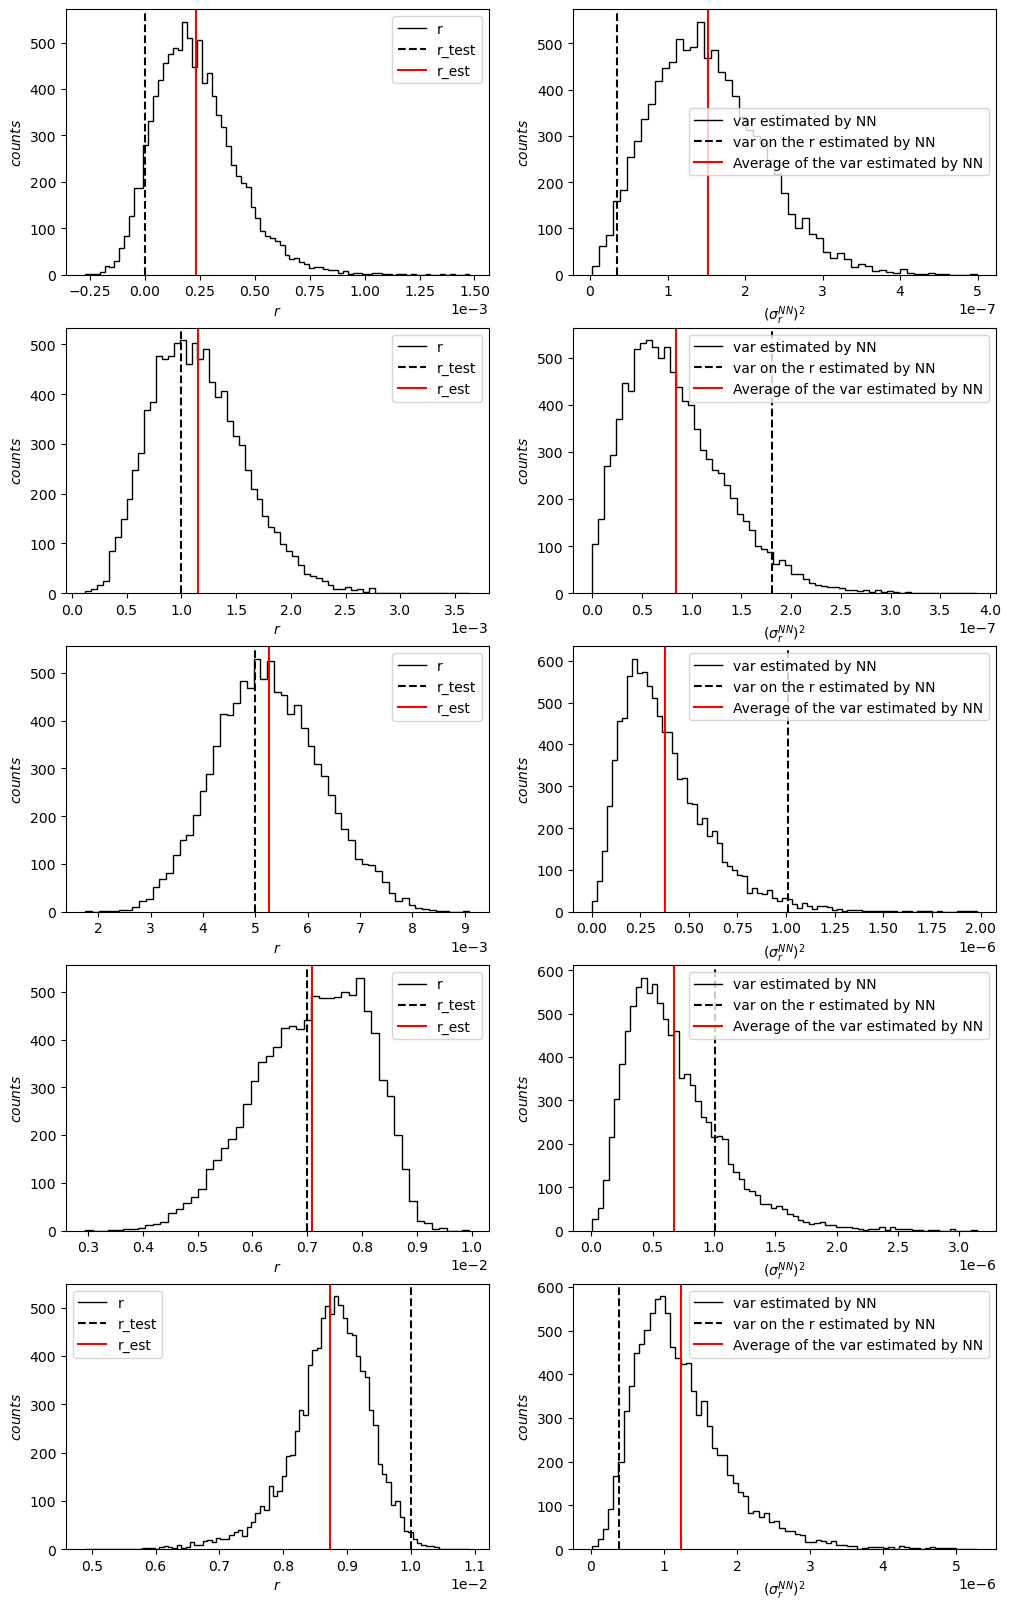

In [13]:
if loss_kind!="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(var_pred[i], bins='fd')
        counts_sigma, bins_sigma = np.histogram(var_pred[i], bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="var estimated by NN",  color='k')
        plt.axvline(sigma_r[i]**2, color="black", linestyle="--", label="var on the r estimated by NN")
        plt.axvline(sigma_est[i]**2, color="red", linestyle="-", label="Average of the var estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$(\sigma_{r}^{NN})^2$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank